# The JHU COVID Database

**Introduction**

The Johns Hopkins University maintains an online COVID-19 database that is uplodaded as a public github repo: https://github.com/CSSEGISandData/COVID-19.git. 

We are interested in mining out some useful information regarding confirmed COVID cases for different countries from this database.

In this article, we will try to analyze the data in the JHU database that contains the information on confirmed COVID cases for different countries/regions and provinces/states. 

In [1]:
import datetime
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import axes
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')

In [2]:
# read all the datasets

confirmed_global = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
death_global = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
confirmed_us = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv")
death_us = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv")
recovered_global = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")


In [3]:
def melt_function(df, val_name):
    """
    Melt wide form data into long form data for operation
    :params df: Long form dataset
    :params df: count value

    :return: long form dataset
    """
    melt_df = df.melt(id_vars=['Country/Region'],
                                var_name='date_ts',
                                value_vars=df.columns[4:],
                                value_name=val_name
                                )
    return melt_df

In [4]:
confrm_melt = melt_function(confirmed_global, 'confirm_val')
death_melt = melt_function(death_global, 'death_val')
recov_melt = melt_function(recovered_global, 'recov_val')
confrm_melt = confrm_melt.rename(columns={'Country/Region': 'Country'})
death_melt = death_melt.rename(columns={'Country/Region': 'Country'})
recov_melt = recov_melt.rename(columns={'Country/Region': 'Country'})
confrm_melt.tail()

,Country,date_ts,confirm_val
287839,West Bank and Gaza,10/13/22,702804
287840,Winter Olympics 2022,10/13/22,535
287841,Yemen,10/13/22,11939
287842,Zambia,10/13/22,333624
287843,Zimbabwe,10/13/22,257827


In [5]:
final_melt = confrm_melt.merge(death_melt, on=['Country', 'date_ts'], how='left', suffixes=('_conf', '_dth')) \
                        .merge(recov_melt, on=['Country', 'date_ts'], how='left', suffixes=('_both', '_rcvr')) 
            #  .join(recov_melt, on=['Country', 'date_ts'], how='left', lsuffix='_conf', rsuffix='_rcv')
final_melt['date_ts'] = pd.to_datetime(final_melt['date_ts'])
final_melt.tail()

,Country,date_ts,confirm_val,death_val,recov_val
45364807,West Bank and Gaza,2022-10-13,702804,5707,0
45364808,Winter Olympics 2022,2022-10-13,535,0,0
45364809,Yemen,2022-10-13,11939,2158,0
45364810,Zambia,2022-10-13,333624,4017,0
45364811,Zimbabwe,2022-10-13,257827,5605,0


In [6]:
sub_df = final_melt[final_melt["Country"].isin(["India", "US", "France", "Brazil", "Germany"])]
sub_df

,Country,date_ts,confirm_val,death_val,recov_val
535,Brazil,2020-01-22,0,0,0
40158,France,2020-01-22,0,0,0
40159,France,2020-01-22,0,0,0
40160,France,2020-01-22,0,0,0
40161,France,2020-01-22,0,0,0
...,...,...,...,...,...
45361149,France,2022-10-13,35119728,152208,0
45361150,France,2022-10-13,35119728,152208,0
45361154,Germany,2022-10-13,34517327,151260,0
45361167,India,2022-10-13,44623997,528857,0


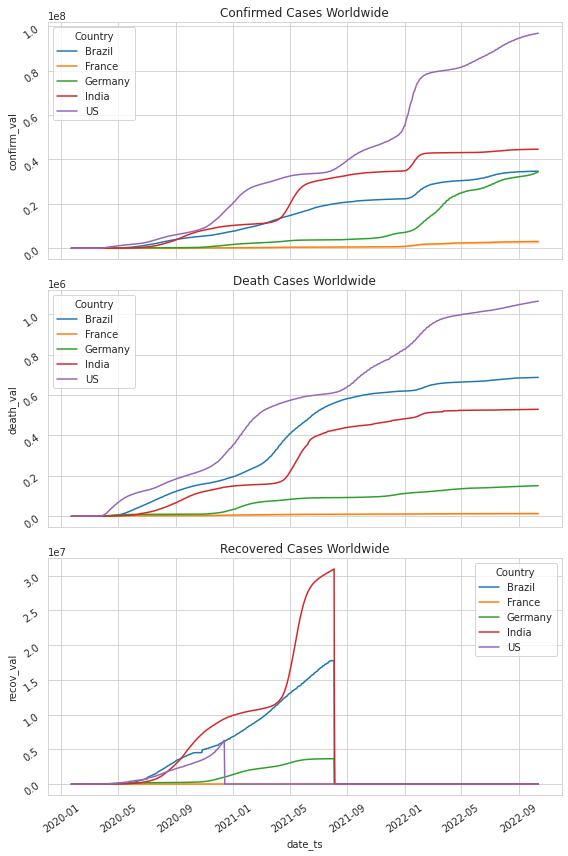

In [7]:
fig, axs =  plt.subplots(3, 1, figsize = (8, 12), squeeze=True, sharex=True)

sns.lineplot(data=sub_df, x="date_ts", y="confirm_val", hue="Country", ax=axs[0])
axs[0].tick_params(labelrotation = 35)
axs[0].set_title("Confirmed Cases Worldwide")

sns.lineplot(data=sub_df, x="date_ts", y="death_val", hue="Country", ax=axs[1])
axs[1].tick_params(labelrotation = 35)
axs[1].set_title("Death Cases Worldwide")

sns.lineplot(data=sub_df, x="date_ts", y="recov_val", hue="Country", ax=axs[2])
axs[2].tick_params(labelrotation = 35)
axs[2].set_title("Recovered Cases Worldwide")

plt.tight_layout()
plt.show()

In [13]:
confirmed_daily = pd.concat([confirmed_global.iloc[:, :4], 
                             confirmed_global.iloc[:, 4:] - confirmed_global.iloc[:, 4:] \
                             .shift(periods=1, axis=1, fill_value=0)], axis=1)

death_daily = pd.concat([death_global.iloc[:, :4], 
                         death_global.iloc[:, 4:] - death_global.iloc[:, 4:] \
                         .shift(periods=1, axis=1, fill_value=0)], axis=1)

recovered_daily = pd.concat([recovered_global.iloc[:, :4],
                             recovered_global.iloc[:, 4:] - recovered_global.iloc[:, 4:] \
                             .shift(periods=1, axis=1, fill_value=0)], axis=1)

In [14]:
confrm_melt = melt_function(confirmed_daily, 'confirm_val')
death_melt = melt_function(death_daily, 'death_val')
recov_melt = melt_function(recovered_daily, 'recov_val')
confrm_melt = confrm_melt.rename(columns={'Country/Region': 'Country'})
death_melt = death_melt.rename(columns={'Country/Region': 'Country'})
recov_melt = recov_melt.rename(columns={'Country/Region': 'Country'})
confrm_melt.tail()

,Country,date_ts,confirm_val
287839,West Bank and Gaza,10/13/22,0
287840,Winter Olympics 2022,10/13/22,0
287841,Yemen,10/13/22,0
287842,Zambia,10/13/22,0
287843,Zimbabwe,10/13/22,29


In [15]:
final_melt = confrm_melt.merge(death_melt, on=['Country', 'date_ts'], how='left', suffixes=('_conf', '_dth')) \
                        .merge(recov_melt, on=['Country', 'date_ts'], how='left', suffixes=('_both', '_rcvr')) 
            #  .join(recov_melt, on=['Country', 'date_ts'], how='left', lsuffix='_conf', rsuffix='_rcv')
final_melt['date_ts'] = pd.to_datetime(final_melt['date_ts'])
final_melt.tail()

,Country,date_ts,confirm_val,death_val,recov_val
45364807,West Bank and Gaza,2022-10-13,0,0,0
45364808,Winter Olympics 2022,2022-10-13,0,0,0
45364809,Yemen,2022-10-13,0,0,0
45364810,Zambia,2022-10-13,0,0,0
45364811,Zimbabwe,2022-10-13,29,1,0


In [16]:
sub_df = final_melt[final_melt["Country"].isin(["India", "US", "France", "Brazil", "Germany"])]
sub_df

,Country,date_ts,confirm_val,death_val,recov_val
535,Brazil,2020-01-22,0,0,0
40158,France,2020-01-22,0,0,0
40159,France,2020-01-22,0,0,0
40160,France,2020-01-22,0,0,0
40161,France,2020-01-22,0,0,0
...,...,...,...,...,...
45361149,France,2022-10-13,64218,62,0
45361150,France,2022-10-13,64218,62,0
45361154,Germany,2022-10-13,114198,165,0
45361167,India,2022-10-13,2678,10,0


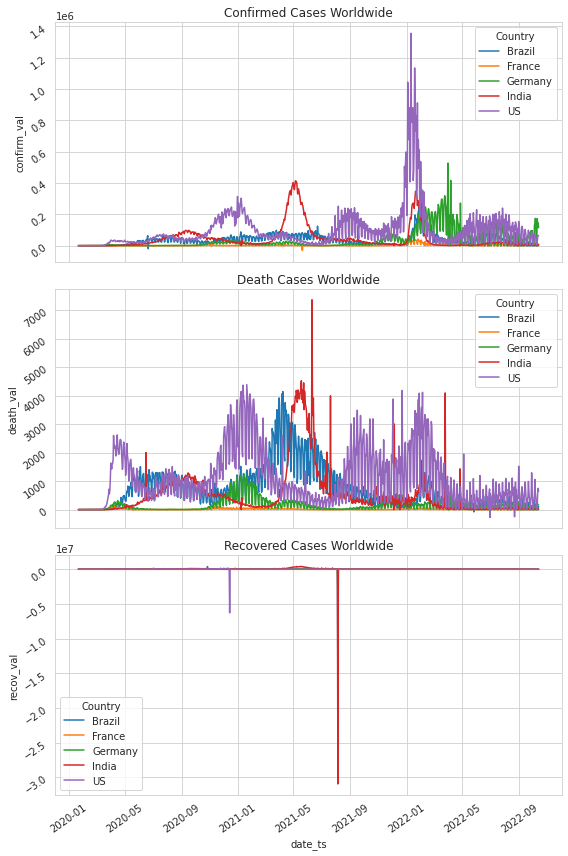

In [17]:
fig, axs =  plt.subplots(3, 1, figsize = (8, 12), squeeze=True, sharex=True)

sns.lineplot(data=sub_df, x="date_ts", y="confirm_val", hue="Country", ax=axs[0])
axs[0].tick_params(labelrotation = 35)
axs[0].set_title("Confirmed Cases Worldwide")

sns.lineplot(data=sub_df, x="date_ts", y="death_val", hue="Country", ax=axs[1])
axs[1].tick_params(labelrotation = 35)
axs[1].set_title("Death Cases Worldwide")

sns.lineplot(data=sub_df, x="date_ts", y="recov_val", hue="Country", ax=axs[2])
axs[2].tick_params(labelrotation = 35)
axs[2].set_title("Recovered Cases Worldwide")

plt.tight_layout()
plt.show()